# Qwen2.5-VL-7B Kaggle Pipeline (13-Step VQA Plan)

This notebook targets the Kaggle dual T4 GPU environment and walks through a 13-step pipeline to solve the multi-choice visual question answering task provided in the `2025-ssafy-14` bundle. Each section matches the onsite workflow you will execute: environment audit, dependency setup, data wrangling, Qwen2.5-VL-7B configuration, validation, and submission authoring.


## 1. Session Snapshot & Resources

Capture the GPU, CPU, and Python runtime details. Keeping this log helps debug Kaggle session mismatches and is required before launching heavy vision-language models.


In [1]:
import os
import platform
import shutil
import subprocess
from pathlib import Path

import torch

print(f"Python: {platform.python_version()}")
print(f"Torch: {torch.__version__}")
print(f"CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for idx in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(idx)
        print(f"  GPU {idx}: {props.name} ({props.total_memory / 1024 ** 3:.1f} GB)")
    try:
        subprocess.run(["nvidia-smi"], check=False)
    except FileNotFoundError:
        print("nvidia-smi command not available.")
else:
    print("CUDA not available; training will run on CPU.")

project_root = Path(os.environ.get("PROJECT_ROOT", Path.home() / "workspace"))
project_root.mkdir(parents=True, exist_ok=True)
print(f"Project root: {project_root.resolve()}")

if project_root.exists():
    total, used, free = shutil.disk_usage(project_root)
    print(
        f"Disk usage for {project_root}: total={total/1e9:.1f} GB | "
        f"used={used/1e9:.1f} GB | free={free/1e9:.1f} GB"
    )


Python: 3.11.14
Torch: 2.4.0+cu124
CUDA devices: 1
  GPU 0: NVIDIA A10G (22.1 GB)
Thu Oct 23 15:48:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    Off |   00000000:00:1E.0 Off |                    0 |
|  0%   22C    P8             11W /  300W |       3MiB /  23028MiB |      1%      Default |
|                                         |               

## 2. Dependency Installation (pip)

Upgrade or pull the exact versions needed for Qwen2.5-VL-7B inference. This list is mirrored in the accompanying documentation so you can track which packages were touched.


In [2]:
%%capture
%pip install --upgrade transformers accelerate einops tiktoken huggingface_hub qwen-vl-utils peft bitsandbytes python-dotenv


## 3. Imports & Global Configuration

Centralise imports, random seeds, plotting rules, and environment flags. Hugging Face tokens are read from the `HF_TOKEN` environment variable (set it in Kaggle Secrets).


In [ ]:
import json
import math
import os
import random
import re
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoProcessor

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = False
pd.set_option("display.max_columns", None)

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cuda.matmul.allow_tf32 = True
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PROJECT_ROOT = Path(os.environ.get("PROJECT_ROOT", Path.home() / "workspace"))
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

WORK_DIR = Path(os.environ.get("WORK_DIR", PROJECT_ROOT / "runs"))
WORK_DIR.mkdir(parents=True, exist_ok=True)

ARTIFACT_DIR = WORK_DIR / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

DATA_KEYWORD = os.environ.get("DATA_KEYWORD", "2025-ssafy-14")
ENV_DATA_ROOT = os.environ.get("DATA_ROOT")
ENV_ARCHIVE_PATH = os.environ.get("DATA_ARCHIVE_PATH")
CUSTOM_SEARCH = os.environ.get("DATA_SEARCH_DIR")

load_dotenv(Path.cwd() / ".env")
HF_TOKEN = "직접 넣어야함"

if HF_TOKEN:
    os.environ["HF_TOKEN"] = HF_TOKEN
    print("[OK] HF_TOKEN loaded from .env/environment.")
else:
    print("[WARN] HF_TOKEN not found. Set it in .env for gated Hugging Face models.")

DATA_SEARCH_DIRS = []
if CUSTOM_SEARCH:
    DATA_SEARCH_DIRS.append(Path(CUSTOM_SEARCH).expanduser())
if ENV_DATA_ROOT:
    DATA_SEARCH_DIRS.append(Path(ENV_DATA_ROOT).expanduser())
DATA_SEARCH_DIRS.extend(
    [
        PROJECT_ROOT,
        PROJECT_ROOT / "data",
        Path.home(),
    ]
)

unique_dirs = []
for path in DATA_SEARCH_DIRS:
    if path is None:
        continue
    path = Path(path).expanduser()
    if path not in unique_dirs:
        unique_dirs.append(path)
DATA_SEARCH_DIRS = unique_dirs


Using device: cuda
[OK] HF_TOKEN loaded from .env/environment.


## 4. Locate & Extract Dataset Archive

Unzip the provided competition bundle inside `/kaggle/working`. The helper covers both archive and already-extracted layouts so you can reuse the notebook without edits.


In [4]:
import zipfile

data_keyword = DATA_KEYWORD
DEFAULT_DATA_ROOT = PROJECT_ROOT / data_keyword
DATA_ROOT = None

if ENV_DATA_ROOT:
    candidate = Path(ENV_DATA_ROOT).expanduser()
    if (candidate / "train.csv").exists():
        DATA_ROOT = candidate
        print(f"Using dataset from DATA_ROOT={DATA_ROOT}")

if DATA_ROOT is None:
    for base in DATA_SEARCH_DIRS:
        csv_path = Path(base).expanduser() / data_keyword / "train.csv"
        if csv_path.exists():
            DATA_ROOT = csv_path.parent
            print(f"Detected dataset at {DATA_ROOT}")
            break

if DATA_ROOT is None:
    archive_candidates = []
    if ENV_ARCHIVE_PATH:
        arch = Path(ENV_ARCHIVE_PATH).expanduser()
        if arch.exists():
            archive_candidates.append(arch)
    for base in DATA_SEARCH_DIRS:
        base = Path(base).expanduser()
        candidate = base / f"{data_keyword}.zip"
        if candidate.exists():
            archive_candidates.append(candidate)
    archive_candidates = sorted({p.resolve() for p in archive_candidates})
    if not archive_candidates:
        raise FileNotFoundError(
            "Dataset not found. Set DATA_ROOT or DATA_ARCHIVE_PATH environment variables."
        )
    archive_path = archive_candidates[0]
    DATA_ROOT = DEFAULT_DATA_ROOT
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    print(f"Extracting {archive_path} -> {DATA_ROOT}")
    with zipfile.ZipFile(archive_path, "r") as zf:
        zf.extractall(DATA_ROOT)
else:
    archive_path = None
    DATA_ROOT.mkdir(parents=True, exist_ok=True)

print(f"DATA_ROOT resolved to: {DATA_ROOT.resolve()}")
print("Contents:")
for child in sorted(DATA_ROOT.iterdir()):
    print(f"- {child.name}")


Detected dataset at /home/ubuntu/workspace/2025-ssafy-14
DATA_ROOT resolved to: /home/ubuntu/workspace/2025-ssafy-14
Contents:
- 251023_Baseline.ipynb
- sample_submission.csv
- test
- test.csv
- train
- train.csv


## 5. Load Metadata & Inspect Structure

Read the CSV metadata, attach absolute image paths, and verify the schema expected by downstream steps.


In [5]:
train_df = pd.read_csv(DATA_ROOT / "train.csv")
test_df = pd.read_csv(DATA_ROOT / "test.csv")
sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv")

train_df["answer"] = train_df["answer"].str.lower()
train_df["image_path"] = train_df["path"].apply(lambda p: str((DATA_ROOT / p).resolve()))
test_df["image_path"] = test_df["path"].apply(lambda p: str((DATA_ROOT / p).resolve()))

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

display(train_df.head())


Train shape: (3887, 9)
Test shape: (3887, 8)
Sample submission shape: (3887, 2)


id                  path                         question        a  \
0  train_0001  train/train_0001.jpg      이 사진 속 운동기구가 설치된 장소는 어디일까요?   학교 운동장   
1  train_0002  train/train_0002.jpg      이 사진에 보이는 전통 한국 건축물은 무엇인가요?       궁궐   
2  train_0003  train/train_0003.jpg            이 사진에서 보이는 탈것은 무엇인가요?  세발 오토바이   
3  train_0004  train/train_0004.jpg             이 사진에서 보이는 새는 무엇인가요?       참새   
4  train_0005  train/train_0005.jpg  이 사진에서 사람들이 모여서 보고 있는 것은 무엇인가요?      해수욕   

       b       c       d answer  \
0     공원  헬스장 내부  쇼핑몰 내부      b   
1      성      사찰      한옥      d   
2   오토바이     자동차     자전거      a   
3    갈매기      백로      오리      c   
4  바다 축제    불꽃놀이     해돋이      d   

                                          image_path  
0  /home/ubuntu/workspace/2025-ssafy-14/train/tra...  
1  /home/ubuntu/workspace/2025-ssafy-14/train/tra...  
2  /home/ubuntu/workspace/2025-ssafy-14/train/tra...  
3  /home/ubuntu/workspace/2025-ssafy-14/train/tra...  
4  /home/ubuntu/workspace/2025-ssafy-14/train/tra...

## 6. Dataset Health Checks

Look at answer balance, ID hygiene, and a sample of image dimensions so we can size model batches safely on T4 GPUs.


In [6]:
label_distribution = train_df["answer"].value_counts().sort_index()
print("Label distribution (train):")
display(label_distribution.to_frame(name="count"))

duplicate_ids = train_df["id"].duplicated().sum()
print(f"Duplicate train IDs: {duplicate_ids}")

null_summary = train_df.isna().sum()
print("Null counts (train):")
display(null_summary[null_summary > 0])

sample_paths = train_df["image_path"].sample(n=min(256, len(train_df)), random_state=SEED)
widths, heights = [], []
for path in sample_paths:
    with Image.open(path) as img:
        w, h = img.size
    widths.append(w)
    heights.append(h)

print(
    f"Sample width px -> mean: {np.mean(widths):.1f}, min: {min(widths)}, max: {max(widths)}"
)
print(
    f"Sample height px -> mean: {np.mean(heights):.1f}, min: {min(heights)}, max: {max(heights)}"
)


Label distribution (train):


count
answer       
a         964
b         958
c         960
d        1005

Duplicate train IDs: 0
Null counts (train):


Series([], dtype: int64)

Sample width px -> mean: 588.4, min: 201, max: 720
Sample height px -> mean: 661.5, min: 233, max: 720


## 7. Visual Spot Checks

Plot a few random training samples to manually confirm the metadata wiring and to capture qualitative notes about lighting and framing.


/tmp/ipykernel_1444/3631422904.py:13: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1444/3631422904.py:13: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1444/3631422904.py:13: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1444/3631422904.py:13: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1444/3631422904.py:13: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1444/3631422904.py:13: UserWarning: Glyph 50631 (\N{HANGUL SYLLABLE EOS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1444/3631422904.py:13: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layou

Sample question: 이 음식은 무엇인가요?
A: 비빔밥과 김치
B: 햄버거와 감자튀김
C: 피자와 감자튀김
D: 치킨과 떡볶이


/home/ubuntu/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47196 (\N{

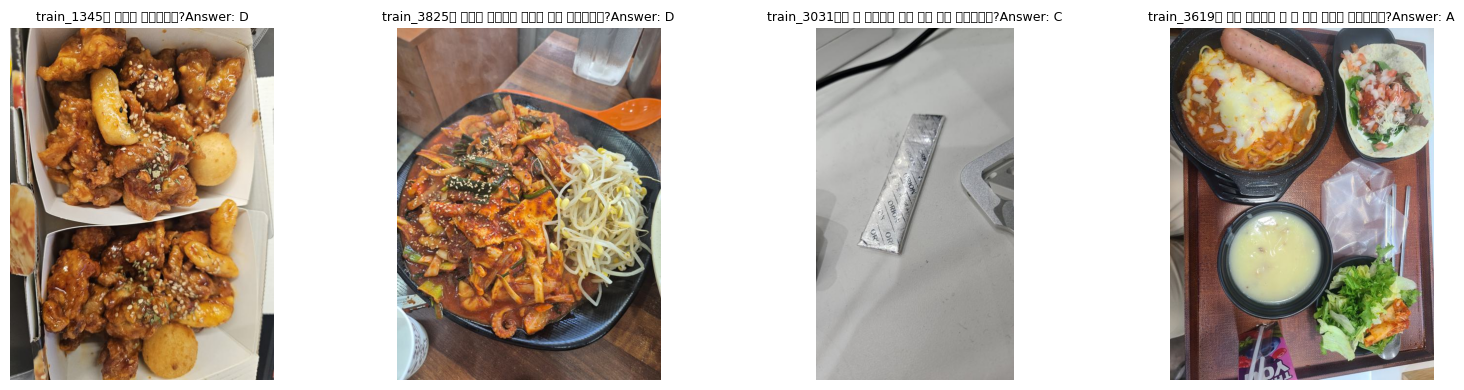

In [7]:
num_examples = 4
fig, axes = plt.subplots(1, num_examples, figsize=(4 * num_examples, 4))
for ax, (_, row) in zip(axes, train_df.sample(num_examples, random_state=SEED).iterrows()):
    with Image.open(row["image_path"]) as img:
        ax.imshow(img)
    ax.axis("off")
    title_lines = [
        row["id"],
        row["question"][:40] + ("..." if len(row["question"]) > 40 else ""),
        f"Answer: {row['answer'].upper()}"
    ]
    ax.set_title("".join(title_lines), fontsize=9)
plt.tight_layout()

sample_row = train_df.sample(1, random_state=SEED).iloc[0]
print("Sample question:", sample_row["question"])
for key in ["a", "b", "c", "d"]:
    print(f"{key.upper()}: {sample_row[key]}")


## 8. Train/Validation Split & Datasets

Create a stratified hold-out set for on-notebook validation. This guards against prompt regressions before spending time on full-test inference.


In [8]:
train_split, val_split = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["answer"],
    random_state=SEED,
)

train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

print(f"Training rows: {len(train_split)}")
print(f"Validation rows: {len(val_split)}")
print("Validation label balance:")
display(val_split["answer"].value_counts().sort_index())


Training rows: 3498
Validation rows: 389
Validation label balance:


answer
a     96
b     96
c     96
d    101
Name: count, dtype: int64

## 9. Prompt Engineering Helpers

Define the system role, user prompt template, and light utility loaders. These pieces keep the generation cell tidy and make it easy to iterate on instructions.


In [9]:
SYSTEM_PROMPT = (
    "You are a Korean visual question answering assistant. "
    "Inspect the provided image carefully and choose the correct option among a, b, c, d. "
    "Respond strictly using a JSON object like {\"answer\": \"a\"}. No explanations, no additional text."
)

CHOICE_KEYS = ["a", "b", "c", "d"]

def create_user_block(row):
    option_lines = "".join(f"{key.upper()}. {row[key]}" for key in CHOICE_KEYS)
    return (f"질문:{row['question']}"f"선택지:{option_lines}"
        "응답 형식: JSON 예시 {\"answer\": \"a\"} (소문자, 따옴표 유지, 설명 금지)."
    )

def build_messages(row):
    return [
        {"role": "system", "content": [{"type": "text", "text": SYSTEM_PROMPT}]},
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": create_user_block(row)},
            ],
        },
    ]


def load_image(path: str) -> Image.Image:
    with Image.open(path) as img:
        return img.convert("RGB")

print("Prompt helpers ready.")


Prompt helpers ready.


## 10. Load Qwen2.5-VL-7B

Authenticate (if needed) and pull the Qwen2.5-VL-7B Instruct checkpoint with mixed precision. Flash-Attention is attempted first with a safe fallback.


In [12]:
# 10번: 안전 로딩(위젯 progress 비활성) + 4bit QLoRA + LoRA 세팅
import os, importlib
import torch

# ---- 0) 위젯/프로그레스바 끄기 (traitlets 'layout' KeyError 회피) ----
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"  # HF Hub 진행바 OFF
try:
    # tqdm이 노트북 위젯을 쓰지 않도록 강제로 text 모드로
    import tqdm as _tqdm
    _tqdm.tqdm = importlib.import_module("tqdm.std").tqdm
except Exception:
    pass
try:
    from huggingface_hub.utils import disable_progress_bars
    disable_progress_bars()
except Exception:
    pass

from huggingface_hub import login
from transformers import (
    AutoModelForImageTextToText,   # 권장 클래스 (Vision2Seq 대체)
    AutoProcessor,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

MODEL_ID = "Qwen/Qwen2.5-VL-7B-Instruct"

# ---- 1) 로그인 (이미 환경변수에 토큰이 있으면 스킵돼도 무방) ----
if HF_TOKEN:
    try:
        login(token=HF_TOKEN, add_to_git_credential=False)
    except Exception as exc:
        print(f"[WARN] Hugging Face login skipped: {exc}")
else:
    print("[WARN] Proceeding without HF login; ensure the model is accessible for your account.")

# ---- 2) 프로세서 ----
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
if hasattr(processor, "tokenizer"):
    # 디코더 전용 모델은 left padding 권장 (추론/학습 경고 방지)
    processor.tokenizer.padding_side = "left"

# ---- 3) 4bit 양자화(QLoRA) ----
compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

base_model = AutoModelForImageTextToText.from_pretrained(
    MODEL_ID,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

# ---- 4) k-bit 학습 준비 + LoRA 어댑터 장착 ----
model = prepare_model_for_kbit_training(base_model)
if hasattr(model, "enable_input_require_grads"):
    model.enable_input_require_grads()
# 학습 중 캐시 사용 비권장(메모리↓)
model.config.use_cache = False

# 타깃 모듈 자동 탐색(없으면 기본셋)
target_candidate_modules = ["q_proj","k_proj","v_proj","o_proj","up_proj","down_proj","gate_proj"]
found = set()
for name, mod in model.named_modules():
    if isinstance(mod, torch.nn.Linear):
        for t in target_candidate_modules:
            if name.endswith(t):
                found.add(t)
found = sorted(found) if found else ["q_proj","k_proj","v_proj","o_proj"]

lora_config = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05,
    bias="none", task_type="CAUSAL_LM",
    target_modules=found,
)
model = get_peft_model(model, lora_config)

# 생성 설정 보정(있으면)
if getattr(model, "generation_config", None) and hasattr(processor, "tokenizer"):
    if model.generation_config.pad_token_id is None:
        model.generation_config.pad_token_id = processor.tokenizer.pad_token_id
    if model.generation_config.eos_token_id is None:
        model.generation_config.eos_token_id = processor.tokenizer.eos_token_id

print("✅ Model loaded with 4-bit quantization and LoRA adapters. Trainable parameters:")
model.print_trainable_parameters()


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Model loaded with 4-bit quantization and LoRA adapters. Trainable parameters:
trainable params: 47,589,376 || all params: 8,339,756,032 || trainable%: 0.5706


## 11. Fine-Tuning Dataset & Collator
데이터프레임을 LoRA 학습에 맞는 포맷으로 변환하고 배치 단위를 처리하는 collate 함수를 준비합니다.


In [13]:
from torch.utils.data import Dataset
import json
import torch

MAX_SEQUENCE_LENGTH = 1024

class VqaFineTuneDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "image_path": row["image_path"],
            "messages": build_messages(row),
            "answer": str(row["answer"]).lower(),
        }

def _build_conversation(sample):
    # 정답 JSON까지 포함한 대화(학습 타깃)
    conversation = sample["messages"] + [
        {
            "role": "assistant",
            "content": [{"type": "text", "text": json.dumps({"answer": sample["answer"]})}],
        }
    ]
    # (1) 프롬프트만
    prompt_text = processor.apply_chat_template(
        sample["messages"], tokenize=False, add_generation_prompt=True
    )
    # (2) 프롬프트 + 정답JSON
    chat_text = processor.apply_chat_template(
        conversation, tokenize=False, add_generation_prompt=False
    )
    return prompt_text, chat_text, sample["image_path"]

# ★ 디코더 전용 모델은 left padding 필수
if hasattr(processor, "tokenizer"):
    processor.tokenizer.padding_side = "left"

def fine_tune_collate_fn(batch):
    images, prompts, full_texts = [], [], []

    for sample in batch:
        prompt_text, chat_text, image_path = _build_conversation(sample)
        images.append(load_image(image_path))
        prompts.append(prompt_text)
        full_texts.append(chat_text)

    # 🔹 프롬프트를 "이미지 포함"으로 인코딩 → 실제 프롬프트 길이(비전 토큰 포함) 획득
    enc_prompt = processor(
        images=images,
        text=prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )
    # 🔹 프롬프트+정답 전체 인코딩
    enc_full = processor(
        images=images,
        text=full_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )

    labels = enc_full["input_ids"].clone()
    # 패딩 토큰은 손실에서 제외
    labels[enc_full["attention_mask"] == 0] = -100

    # ✅ 패딩 방식과 무관하게 "프롬프트 구간"만 정확히 마스킹
    for i in range(labels.size(0)):
        full_mask   = enc_full["attention_mask"][i].bool()          # 전체에서 non-pad 위치
        prompt_len  = int(enc_prompt["attention_mask"][i].sum().item())  # 프롬프트의 non-pad 길이
        nonpad_idx  = torch.nonzero(full_mask, as_tuple=False).squeeze(-1)
        prompt_idx  = nonpad_idx[:prompt_len]   # non-pad 중 앞쪽 prompt_len개가 '프롬프트 토큰'
        labels[i, prompt_idx] = -100            # 프롬프트 구간 손실 제외

    enc_full["labels"] = labels
    return enc_full

train_dataset = VqaFineTuneDataset(train_split)
if len(val_split) <= 128:
    val_eval_df = val_split.copy().reset_index(drop=True)
else:
    val_eval_df = val_split.sample(n=128, random_state=SEED).reset_index(drop=True)
val_dataset = VqaFineTuneDataset(val_eval_df)
print(f"Train dataset size: {len(train_dataset)} | Eval dataset size: {len(val_dataset)}")


Train dataset size: 3498 | Eval dataset size: 128


## 12. LoRA Fine-Tuning (1 Epoch)
T4 GPU에서 약 1시간 내에 수렴하도록 4비트 LoRA 학습 설정을 구성합니다.


In [ ]:
# 12단계: TrainingArguments 하이퍼파라미터 조정 + Trainer 실행 (성능/안정성 우선)
import inspect
from transformers import TrainingArguments, Trainer

if hasattr(processor, "tokenizer"):
    processor.tokenizer.padding_side = "left"

OUTPUT_DIR = WORK_DIR / "qwen25vl_lora"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

GPU_MEM_GB = 0.0
if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    GPU_MEM_GB = props.total_memory / 1024 ** 3

PER_DEVICE_BATCH = 2 if GPU_MEM_GB >= 22 else 1
TARGET_EFFECTIVE_BATCH = int(os.environ.get("EFFECTIVE_BATCH_SIZE", 16))
GRADIENT_ACCUMULATION = max(1, TARGET_EFFECTIVE_BATCH // PER_DEVICE_BATCH)
EPOCHS = int(os.environ.get("NUM_EPOCHS", 3))
LEARNING_RATE = float(os.environ.get("LEARNING_RATE", 5e-5))
WARMUP_RATIO = float(os.environ.get("WARMUP_RATIO", 0.05))

print(
    f"GPU memory: {GPU_MEM_GB:.1f} GB | per_device_batch={PER_DEVICE_BATCH} | "
    f"grad_accum={GRADIENT_ACCUMULATION} | epochs={EPOCHS}"
)

bf16_enabled = torch.cuda.is_available() and torch.cuda.is_bf16_supported()

common_kwargs = dict(
    output_dir=str(OUTPUT_DIR),
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_BATCH,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=3,
    report_to="none",
    bf16=bf16_enabled,
    fp16=not bf16_enabled,
    optim="adamw_bnb_8bit",
    dataloader_num_workers=2,
    gradient_checkpointing=True,
    max_grad_norm=0.3,
    remove_unused_columns=False,
)

max_steps_env = os.environ.get("MAX_TRAIN_STEPS")
if max_steps_env:
    common_kwargs["max_steps"] = int(max_steps_env)

sig = inspect.signature(TrainingArguments.__init__)
if "evaluation_strategy" in sig.parameters:
    common_kwargs["evaluation_strategy"] = "epoch"
elif "eval_strategy" in sig.parameters:
    common_kwargs["eval_strategy"] = "epoch"

training_args = TrainingArguments(**common_kwargs)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=fine_tune_collate_fn,
)

train_result = trainer.train()
print("Training metrics:", getattr(train_result, "metrics", {}))

try:
    eval_metrics = trainer.evaluate(eval_dataset=val_dataset)
    print("Eval metrics:", eval_metrics)
except Exception as e:
    print(f"(info) Evaluation skipped due to: {e}")

adapter_path = OUTPUT_DIR / "lora_adapter"
model.save_pretrained(adapter_path)
processor.save_pretrained(OUTPUT_DIR / "processor")
print(f"LoRA fine-tuning complete. Adapter weights saved to {adapter_path}")


GPU memory: 22.1 GB | per_device_batch=2 | grad_accum=8 | epochs=3


/home/ubuntu/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ubuntu/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


## 13. Inference Utilities

Batch the prompts, launch generation, and parse the letter from JSON. The helpers are shared by validation and submission stages.


In [12]:
LETTER_JSON_PATTERN = re.compile(r'"answer"\s*:\s*"([abcd])"')
LETTER_FALLBACK_PATTERN = re.compile(r"([abcd])")

PRED_BATCH_SIZE = 2
MAX_NEW_TOKENS = 24

def decode_answer_text(text: str) -> str:
    lowered = text.lower()
    match = LETTER_JSON_PATTERN.search(lowered)
    if match:
        return match.group(1)
    match = LETTER_FALLBACK_PATTERN.search(lowered)
    if match:
        return match.group(1)
    return "a"


def run_inference(records, batch_size: int = PRED_BATCH_SIZE, keep_raw: bool = False):
    outputs = []
    raw_outputs = [] if keep_raw else None
    for start in tqdm(range(0, len(records), batch_size)):
        batch = records[start : start + batch_size]
        prompts = []
        images = []
        for row in batch:
            prompts.append(
                processor.apply_chat_template(
                    build_messages(row),
                    tokenize=False,
                    add_generation_prompt=True,
                )
            )
            images.append(load_image(row["image_path"]))
        inputs = processor(
            text=prompts,
            images=images,
            return_tensors="pt",
            padding=True,
        ).to(model.device)
        with torch.inference_mode():
            generated = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=0.0,
                do_sample=False,
            )
        decoded = processor.batch_decode(generated, skip_special_tokens=True)
        for response in decoded:
            answer = decode_answer_text(response)
            outputs.append(answer)
            if keep_raw:
                raw_outputs.append(response)
    if keep_raw:
        return outputs, raw_outputs
    return outputs

print("Inference helpers initialised.")


Inference helpers initialised.


## 14. Validation Run

Sanity-check the prompt and parsing logic on a stratified slice of the validation split before running the full test sweep.


In [16]:
# 12. Validation Run (OOM-safe, Kaggle T4 대응)
import gc, re, torch
from tqdm.auto import tqdm

# decoder-only 구조 → 반드시 left padding
if hasattr(processor, "tokenizer"):
    processor.tokenizer.padding_side = "left"

VALIDATION_LIMIT = min(32, len(val_split))  # 너무 많으면 VRAM 터짐
validation_subset = val_split.sample(VALIDATION_LIMIT, random_state=SEED).reset_index(drop=True)
validation_records = validation_subset.to_dict("records")

val_preds, raw_responses = [], []

def _infer_one(row, idx):
    img_path = row["image_path"] if "image_path" in row else row["image"]
    image = load_image(img_path)
    messages = build_messages(row)
    chat_text = processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=False
    )
    inputs = processor(
        images=[image],
        text=[chat_text],
        return_tensors="pt",
        padding=True,
    ).to(model.device)

    # ✅ 진행상황 출력
    print(f"[{idx+1}/{len(validation_records)}] Processing: {img_path}")

    with torch.inference_mode():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=8,
            do_sample=False,
            use_cache=False
        )

    text = processor.batch_decode(output_ids, skip_special_tokens=True)[0]

    # 즉시 메모리 정리
    del inputs, output_ids, image
    gc.collect(); torch.cuda.empty_cache()

    return text


for idx, row in enumerate(tqdm(validation_records, total=len(validation_records))):
    try:
        out_text = _infer_one(row, idx)
        raw_responses.append(out_text)
        print(f" → Output: {out_text[:100]!r}")  # 첫 100자만 미리보기

        m = re.search(r'{"\s*answer"\s*:\s*"(a|b|c|d)"}', out_text.strip(), flags=re.I)
        pred = m.group(1).lower() if m else "a"

    except Exception as e:
        print(f"[!] Error on sample {idx}: {e}")
        pred = "a"

    val_preds.append(pred)

validation_subset["prediction"] = val_preds
validation_subset["raw_response"] = raw_responses
validation_subset["is_correct"] = (
    validation_subset["answer"].str.lower() == validation_subset["prediction"]
)

val_accuracy = validation_subset["is_correct"].mean()
print(f"\n✅ Validation accuracy on {len(validation_subset)} samples: {val_accuracy:.4f}")

display(validation_subset.head())
display(
    validation_subset[validation_subset["is_correct"] == False][
        ["id", "answer", "prediction", "raw_response"]
    ].head()
)


  0%|          | 0/32 [00:00<?, ?it/s]

[1/32] Processing: /home/ubuntu/workspace/2025-ssafy-14/train/train_0866.jpg


/home/ubuntu/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


 → Output: 'system\nYou are a Korean visual question answering assistant. Inspect the provided image carefully an'
[2/32] Processing: /home/ubuntu/workspace/2025-ssafy-14/train/train_2264.jpg
 → Output: 'system\nYou are a Korean visual question answering assistant. Inspect the provided image carefully an'
[3/32] Processing: /home/ubuntu/workspace/2025-ssafy-14/train/train_3237.jpg
 → Output: 'system\nYou are a Korean visual question answering assistant. Inspect the provided image carefully an'
[4/32] Processing: /home/ubuntu/workspace/2025-ssafy-14/train/train_2105.jpg
 → Output: 'system\nYou are a Korean visual question answering assistant. Inspect the provided image carefully an'
[5/32] Processing: /home/ubuntu/workspace/2025-ssafy-14/train/train_0419.jpg
 → Output: 'system\nYou are a Korean visual question answering assistant. Inspect the provided image carefully an'
[6/32] Processing: /home/ubuntu/workspace/2025-ssafy-14/train/train_3172.jpg
 → Output: 'system\nYou are a Korean vis

id                  path                         question  \
0  train_0866  train/train_0866.jpg              이 사진에 보이는 꽃은 무엇인가요?   
1  train_2264  train/train_2264.jpg  사진 속 원숭이의 행동으로 알 수 있는 것은 무엇인가요?   
2  train_3237  train/train_3237.jpg         이 사진에서 사람들이 무엇을 하고 있습니까?   
3  train_2105  train/train_2105.jpg      이 사진에서 볼 수 있는 자연 경관은 무엇인가요?   
4  train_0419  train/train_0419.jpg        이 음식 중 연어가 포함된 음식은 무엇인가요?   

                 a             b               c                   d answer  \
0               장미            튤립            해바라기                  수국      d   
1   원숭이가 음식을 먹고 있다  원숭이들이 싸우고 있다  원숭이가 나무를 타고 있다  아기가 엄마 원숭이에게 안겨 있다      d   
2  와인잔을 들고 건배하고 있다      책을 읽고 있다      커피를 마시고 있다           운동을 하고 있다      a   
3           사막과 바다        해변과 절벽            산과 강               호수와 숲      c   
4              돈가스         연어 덮밥            된장찌개               김치볶음밥      b   

                                          image_path prediction  \
0  /home/ubuntu/workspace/2025-ssafy-14/train/tra...          a   
1  /home/ubuntu/workspace/2025-ssafy-14/train/tra...          a   
2  /home/ubuntu/workspace/2025-ssafy-14/train/tra...          a   
3  /home/ubuntu/workspace/2025-ssafy-14/train/tra...          a   
4  /home/ubuntu/workspace/2025-ssafy-14/train/tra...          a   

                                        raw_response  is_correct  
0  system\nYou are a Korean visual question answe...       False  
1  system\nYou are a Korean visual question answe...       False  
2  system\nYou are a Korean visual question answe...        True  
3  system\nYou are a Korean visual question answe...       False  
4  system\nYou are a Korean visual question answe...       False

id answer prediction  \
0  train_0866      d          a   
1  train_2264      d          a   
3  train_2105      c          a   
4  train_0419      b          a   
5  train_3172      b          a   

                                        raw_response  
0  system\nYou are a Korean visual question answe...  
1  system\nYou are a Korean visual question answe...  
3  system\nYou are a Korean visual question answe...  
4  system\nYou are a Korean visual question answe...  
5  system\nYou are a Korean visual question answe...

## 15. Full Test Inference & Submission

Generate answers for the official test set and export `submission.csv` under `/kaggle/working` for Kaggle upload.


In [ ]:
test_records = test_df.to_dict("records")

test_predictions = run_inference(test_records)
submission = pd.DataFrame({
    "id": test_df["id"],
    "answer": test_predictions,
})

submission_path = WORK_DIR / "submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")

display(submission.head())


### Notes & Next Steps

- If generation drifts away from lowercase JSON, tighten `SYSTEM_PROMPT` or add few-shot exemplars (image + JSON reply) inside `build_messages`.
- Increase `VALIDATION_LIMIT` once the prompt stabilises to estimate leaderboard expectations more accurately.
- Consider batching with `batch_size=3` if GPU memory allows to speed up the final sweep on the dual T4 setup.
